# 0.0 - Imports

In [86]:
import re
import io
import tensorflow        as tf
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text     import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



## 0.1 loading Data

In [2]:
path = r'D:\projetos\Projetos_NLP\text_classifier\data\interim\20220203_notebook0.0_data_filter.csv'
df = pd.read_csv(path)

# 1.0 Preprocessing

In [33]:
df['review_text'] = df['review_text'].apply(str)

## 1.1 Configuration to model and tokenization

In [65]:
vocab_size = 20000 # Quantidade de palavras
embedding_dim = 16
max_length = 1000 # Tamanho de cada frase
trunc_type = 'post'
padding_type = 'post'
oov_tok = 'XXXX'
training_size = 90000

## 1.2 Train and Test

In [66]:
len(df)

129080

In [67]:
df.columns

Index(['Unnamed: 0', 'recommend_to_a_friend', 'review_text',
       'recommend_to_a_friend_num'],
      dtype='object')

In [68]:
sentences = df['review_text']
labels = df['recommend_to_a_friend_num']

In [69]:
training_sentences = sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sentences[training_size:]
testing_labels = labels[training_size:]

In [70]:
testing_labels_final = np.array(testing_labels)
training_labels_final = np.array(training_labels)

### Distribuition of the data train and test

In [71]:
training_labels.value_counts(normalize=True)

1    0.744189
0    0.255811
Name: recommend_to_a_friend_num, dtype: float64

In [72]:
testing_labels.value_counts(normalize=True)

1    0.718756
0    0.281244
Name: recommend_to_a_friend_num, dtype: float64

1- Sim (Recomendaria o produto para um amigo)

2 - Não (Não recomendaria um produto para um amigo)

## 1.3 Tokenização

In [73]:
tokenizer = Tokenizer(  num_words = vocab_size,
                        oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences) # Tokenizando as palavras do treinamento

word_index = tokenizer.word_index

# Criando a sequência de palavras para o treinamento, Substituindo as palavras pelos seus tokens.
training_sequences = tokenizer.texts_to_sequences(training_sentences) 
training_padded = pad_sequences(training_sequences,
                                maxlen= max_length,
                                padding=padding_type,
                                truncating= trunc_type)

# Repetindo o processo para os dados de teste.
testing_sequences = tokenizer.texts_to_sequences(testing_sentences) 
testing_padded = pad_sequences(testing_sequences,
                                maxlen= max_length,
                                padding=padding_type,
                                truncating= trunc_type)


# 2.0 Model

## 2.1 Build Model - Model_1

In [78]:
# Buid Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), # Embedding das palavras tokenizadas
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

# Compile
loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']

model.compile(  loss= loss,
                optimizer = optimizer,
                metrics = metrics)

In [79]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 16)          320000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 6)                 102       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 320,109
Trainable params: 320,109
Non-trainable params: 0
_________________________________________________________________


### 2.1.1 Model Fit

In [80]:
n_epochs = 15

In [81]:
history = model.fit(training_padded,
                    training_labels_final,
                    epochs = n_epochs,
                    validation_data = (testing_padded, testing_labels_final),
                    verbose = 2)

Epoch 1/15
2813/2813 - 35s - loss: 0.5116 - accuracy: 0.7602 - val_loss: 0.4228 - val_accuracy: 0.7858 - 35s/epoch - 12ms/step
Epoch 2/15
2813/2813 - 29s - loss: 0.3181 - accuracy: 0.8635 - val_loss: 0.3087 - val_accuracy: 0.8676 - 29s/epoch - 10ms/step
Epoch 3/15
2813/2813 - 31s - loss: 0.2632 - accuracy: 0.8969 - val_loss: 0.2866 - val_accuracy: 0.8888 - 31s/epoch - 11ms/step
Epoch 4/15
2813/2813 - 32s - loss: 0.2473 - accuracy: 0.9065 - val_loss: 0.2815 - val_accuracy: 0.8926 - 32s/epoch - 11ms/step
Epoch 5/15
2813/2813 - 32s - loss: 0.2362 - accuracy: 0.9123 - val_loss: 0.2717 - val_accuracy: 0.8927 - 32s/epoch - 11ms/step
Epoch 6/15
2813/2813 - 31s - loss: 0.2277 - accuracy: 0.9172 - val_loss: 0.2711 - val_accuracy: 0.8979 - 31s/epoch - 11ms/step
Epoch 7/15
2813/2813 - 28s - loss: 0.2212 - accuracy: 0.9198 - val_loss: 0.2644 - val_accuracy: 0.8985 - 28s/epoch - 10ms/step
Epoch 8/15
2813/2813 - 29s - loss: 0.2163 - accuracy: 0.9222 - val_loss: 0.2653 - val_accuracy: 0.8978 - 29s/ep

### 2.1.3 Results

In [89]:
def plot_graphs(history, string):
    sns.set()
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

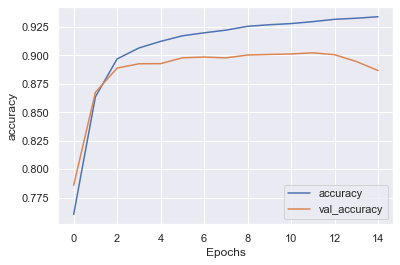

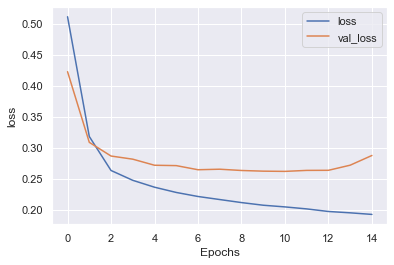

In [90]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# 3.0 Embeddings

In [91]:
# Obtendo os resultados da camada de embedding (primeira camada)
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # Shape: (Vocab_size, embedding_dim)
# 20000 Palavras e 16 dimensões

(20000, 16)


In [92]:
# Para sermos capazes de plotar as palavras como vetores, devemos obter o índice de palavras ao contrário
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

### 3.1 Escrevendo os vetores em formatos de metadados

In [93]:
out_v = io.open(r'D:\projetos\Projetos_NLP\text_classifier\data\external\vecs.tsv', 'w', encoding='utf-8')
out_m = io.open(r'D:\projetos\Projetos_NLP\text_classifier\data\external\meta.tsv', 'w', encoding='utf-8')

In [94]:
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_m.close()
out_v.close()

O projecto TensorFlow lê esse tipo de arquivo e usa os dados para plotar um gráfico em 3D